In [1]:
import numpy as np
import pandas as pd
from functools import reduce
from adjustText import adjust_text
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact
from src.visualization.plot import *
import seaborn as sns
from src.dataset import bulkDataset

from src.settings import *
plt.style.use(PlotStyle)

%load_ext autoreload
%autoreload 2

In [2]:
data_processed_folder = '../data/processed'
dataset = bulkDataset(data_processed_folder)
metadata= dataset.metadata

  2024-06-03 13:41:36,967 - src.dataset._dataset - _getMetadata - INFO - Appending clinical_and_sequencing_metadata feature estimated from clinical_sequencing sequencing into metadata
  2024-06-03 13:41:36,976 - src.dataset._dataset - _getMetadata - INFO - Appending mutation_signature feature estimated from WES sequencing into metadata
  2024-06-03 13:41:36,981 - src.dataset._dataset - _getMetadata - INFO - Attaching WES prefix to feature names in mutation_signature
  2024-06-03 13:41:36,982 - src.dataset._dataset - _getMetadata - INFO - Appending somatic_mutation_burden feature estimated from WES sequencing into metadata
  2024-06-03 13:41:36,986 - src.dataset._dataset - _getMetadata - INFO - Attaching WES prefix to feature names in somatic_mutation_burden
  2024-06-03 13:41:36,987 - src.dataset._dataset - _getMetadata - INFO - Appending cga_wes_features feature estimated from WES sequencing into metadata
  2024-06-03 13:41:36,993 - src.dataset._dataset - _getMetadata - INFO - Attachi

# Define the Figure and Table output

In [8]:
RnaTableFile = '../report/table/Table_2_trial_16-466_RNA-Seq_Data.xlsx'

# RNA-Seq Dwonstreem scores

In [9]:
rna = metadata.loc[metadata.BulkRNA_Profile==True,:]
rna.index.name='SampleID'
rna_sheets ={}

Samples with TiN < 50: N = 0


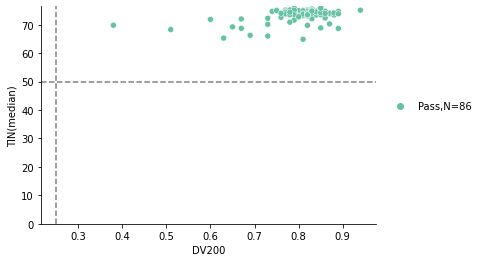

In [10]:
## based the CIDC the prior cross-site concordance study
dv200_cutoff = 0.25
tin_cutoff = 50
tb = rna.copy()
tb['TiN_Fail'] = tb['RNA_DV200'] <dv200_cutoff
tb['TiN_Fail_Label'] = tb['TiN_Fail'].map(lambda x: 'Fail' if x else 'Pass')
total_n = tb['TiN_Fail_Label'].value_counts().to_dict()
tb['TiN_Fail_Label'] = tb['TiN_Fail_Label'].map(lambda x: f'{x},N={total_n[x]}')
ax = sns.scatterplot(data=tb,y='bulkRNA_TIN(median)',x='RNA_DV200',hue='TiN_Fail_Label',palette='Set2')
# ax.set_xlim([0,tb.shape[0]+1])
ax.set_ylim([0,ax.get_ylim()[1]+0.05])
ax.axhline(y=tin_cutoff,linestyle='--',color='gray')
ax.axvline(x=dv200_cutoff,linestyle='--',color='gray')
ax.legend(loc=(1.03,0.5),title='',frameon=False)
ax.set(ylabel='TIN(median)',xlabel='DV200')
print(f'Samples with TiN < {tin_cutoff}: N =', tb['TiN_Fail'].sum())

In [11]:
rna_sheets['TableA RNA_QC_Metrics']= rna[['bulkRNA_TIN(median)','RNA_DV200']].copy()

## PAM50

In [12]:
rna.loc[rna.BestResponse!='N/A',:].Patient.nunique()

26

In [13]:
rna.loc[rna.Timepoint=='Baseline','BestResponse'].value_counts()

II-III    19
0-I        6
N/A        2
Name: BestResponse, dtype: int64

In [14]:
(
    rna.loc[rna.Timepoint=='Baseline',['bulkRNA_PAM50','BestResponse','Treatment_Arm','er_status']].
    replace('N/A',np.nan).
    dropna()
)['BestResponse'].value_counts()

II-III    19
0-I        6
Name: BestResponse, dtype: int64

Text(0.7, 0.11, 'Odds=18.00\nPvalue=0.031')

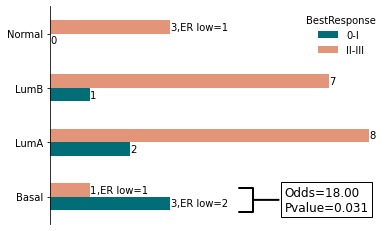

In [15]:
dt_sub = (
    rna.loc[rna.Timepoint=='Baseline',['bulkRNA_PAM50','BestResponse','Treatment_Arm','er_status']].
    replace('N/A',np.nan).
    dropna()
)
er_low_counts = dt_sub.loc[dt_sub.er_status=='Weakly Positive (1-10% cell staining)',['bulkRNA_PAM50','BestResponse']].value_counts()
x='BestResponse'
y='Number of Pts'
hue='bulkRNA_PAM50'
palette = COLOR_PAlETTE[x]
order=['0-I','II-III']
# hue_order=['Normal','Basal','LumA','LumB','Her2']
dt = (
    dt_sub.
    value_counts().
    rename(y).
    reset_index()
    )
dt = (
    dt_sub.
    drop(['Treatment_Arm','er_status'],axis=1).
    value_counts().
    rename(y).
    reset_index()
    )
ax = dt.pivot(index=hue,columns=x,values=y).plot(kind='barh',stacked=False,color=palette)

ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[0],
             [ f",ER low={er_low_counts[(x.get_text(),'0-I')]}" if (x.get_text(),'0-I') in er_low_counts else '' for  x in ax.get_yticklabels()],
             padding=7,
             )
ax.bar_label(ax.containers[1],
             [ f",ER low={er_low_counts[(x.get_text(),'II-III')]}" if (x.get_text(),'II-III') in er_low_counts else '' for  x in ax.get_yticklabels()],
             padding=7,
             )
ax.axes.get_xaxis().set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set(ylabel='')

dt_dum = pd.get_dummies(dt_sub)
table = pd.crosstab(dt_dum['BestResponse_0-I'],dt_dum['bulkRNA_PAM50_Basal'])
ax.annotate('Odds={:.2f}\nPvalue={:.3f}'.format(*fisher_exact(table,alternative='greater')), xy=(.6, 0.11), xytext=(.7, .11), xycoords='axes fraction', 
            fontsize=12, ha='left', va='center',
            bbox=dict(boxstyle='square', fc='white', color='k'),
            arrowprops=dict(arrowstyle='-[, widthB=1, lengthB=1.2', lw=2.0, color='k'))



In [16]:
table

bulkRNA_PAM50_Basal,0,1
BestResponse_0-I,,
0,18,1
1,3,3


## BluePrint result

  - high risk lum-> LumA
  - low rist lum-> LumB

In [17]:
dt_sub = (
    rna.loc[(rna.Timepoint=='Baseline')&
            (rna.BluePrint!='QNS'),['BluePrint','BestResponse','bulkRNA_PAM50','Treatment_Arm','er_status']].
    replace('N/A',np.nan).
    dropna()
)
pd.crosstab(dt_sub['BluePrint'],dt_sub['bulkRNA_PAM50'])

bulkRNA_PAM50,Basal,LumA,LumB,Normal
BluePrint,,,,
Basal,4,0,0,1
LumA,0,1,1,0
LumB,0,4,3,0


In [18]:
dt_sub

,BluePrint,BestResponse,bulkRNA_PAM50,Treatment_Arm,er_status
SampleID,,,,,
RP-2423_16466_1_060517,LumB,0-I,LumB,Chemo->ICI,Positive (>10% cell staining)
RP-2423_16466_2_061517,LumB,II-III,LumB,ICI->Chemo,Positive (>10% cell staining)
RP-2423_16466_3_070717,LumB,II-III,LumA,ICI->Chemo,Positive (>10% cell staining)
RP-2423_16466_4_071317,LumB,II-III,LumB,ICI->Chemo,Positive (>10% cell staining)
RP-2423_16466_7_121217,Basal,0-I,Basal,Chemo->ICI,Positive (>10% cell staining)
RP-2423_16466_8_032018,Basal,0-I,Basal,ICI->Chemo,Weakly Positive (1-10% cell staining)
RP-2423_16466_9_060118,LumB,II-III,LumA,ICI->Chemo,Positive (>10% cell staining)
RP-2423_16466_10_071018,LumB,II-III,LumA,Chemo->ICI,Positive (>10% cell staining)
RP-2423_16466_12_082018,Basal,II-III,Normal,ICI->Chemo,Weakly Positive (1-10% cell staining)


In [19]:
dt_sub['BluePrint'].value_counts()

LumB     7
Basal    5
LumA     2
Name: BluePrint, dtype: int64

'Odds=1.88\nPvalue=0.500'

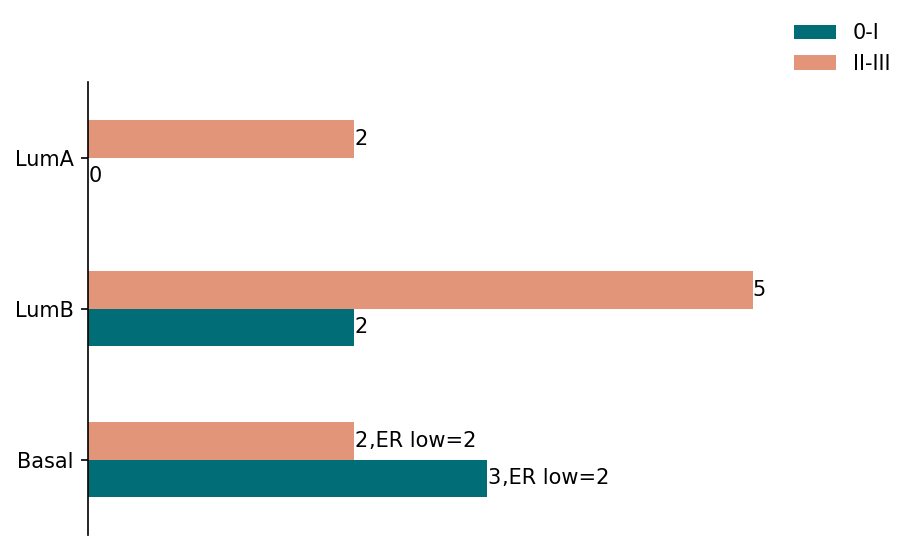

In [20]:
dt_sub = (
    rna.loc[(rna.Timepoint=='Baseline')&
            (rna.BluePrint!='QNS'),['BluePrint','BestResponse','Treatment_Arm','er_status']].
    replace('N/A',np.nan).
    dropna()
)

er_low_counts = dt_sub.loc[dt_sub.er_status=='Weakly Positive (1-10% cell staining)',['BluePrint','BestResponse']].value_counts()
x='BestResponse'
y='Number of Pts'
hue='BluePrint'
palette = COLOR_PAlETTE[x]
order=['0-I','II-III']
# hue_order=['Normal','Basal','LumA','LumB','Her2']
dt = (
    dt_sub.
    value_counts().
    rename(y).
    reset_index()
    )
dt = (
    dt_sub.
    drop(['Treatment_Arm','er_status'],axis=1).
    value_counts().
    rename(y).
    reset_index()
    )
fig,ax=plt.subplots(1,1,dpi=150)
dt.pivot(index=hue,columns=x,values=y).loc[['Basal','LumB','LumA'],:].plot(kind='barh',stacked=False,color=palette,ax=ax)

ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[0],
             [ f",ER low={er_low_counts[(x.get_text(),'0-I')]}" if (x.get_text(),'0-I') in er_low_counts else '' for  x in ax.get_yticklabels()],
             padding=7,
             )
ax.bar_label(ax.containers[1],
             [ f",ER low={er_low_counts[(x.get_text(),'II-III')]}" if (x.get_text(),'II-III') in er_low_counts else '' for  x in ax.get_yticklabels()],
             padding=7,
             )
ax.axes.get_xaxis().set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set(ylabel='')

dt_dum = pd.get_dummies(dt_sub)
table = pd.crosstab(dt_dum['BestResponse_II-III'],dt_dum['BluePrint_LumB'])
# ax.annotate('Odds={:.2f}\nPvalue={:.3f}'.format(*fisher_exact(table,alternative='greater')), xy=(.8, 0.14), xytext=(.9, .14), xycoords='axes fraction', 
#             fontsize=12, ha='left', va='center',
#             bbox=dict(boxstyle='square', fc='white', color='k'),
#             arrowprops=dict(arrowstyle='-[, widthB=1, lengthB=1.2', lw=2.0, color='k'))
ax.legend(loc=(1,1))
'Odds={:.2f}\nPvalue={:.3f}'.format(*fisher_exact(table,alternative='greater'))

In [21]:
table

BluePrint_LumB,0,1
BestResponse_II-III,,
0,3,2
1,4,5


## PAM50 subtype

In [22]:
rna.loc[rna.Timepoint=='Baseline','bulkRNA_PAM50'].value_counts(normalize=True)

LumB      0.370370
LumA      0.370370
Basal     0.148148
Normal    0.111111
Name: bulkRNA_PAM50, dtype: float64

In [23]:
df = dataset.load('Pathways_Response')
deg = dataset.load('DEGs_Response')

In [24]:
df.Treatment_Arm.unique()

array(['Chemo->ICI', 'ICI->Chemo', 'Chemo->ICI,ICI->Chemo'], dtype=object)

## Samples from both Arm

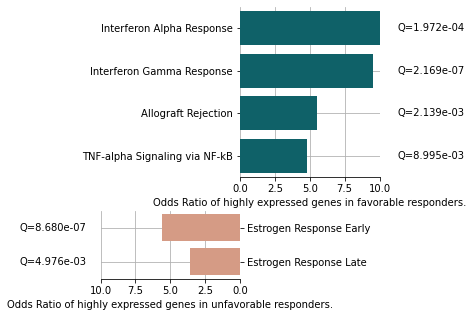

In [25]:
sub_df = df.loc[(df.Method=='DESeq2')&
                (df['Adjusted P-value']<0.05)&
                (df.Timepoint=='Baseline')&
                (df.Treatment_Arm=='Chemo->ICI,ICI->Chemo'),
                :]

x='Odds Ratio'
y='Term'
hue='Direction'


fig,axs= plt.subplot_mosaic([['A','B'],
                             ['A','B'],
                             ['C','D']],figsize=(5,5))
fig.delaxes(axs['A'])
fig.delaxes(axs['D'])
## Up
data = sub_df.loc[sub_df.Direction=='Up',:].copy()
data[y] = data[y].astype(str)
order = data.sort_values(x,ascending=False)['Term']
ax = axs['B']
sns.barplot(data=data,x=x,y=y,ax=ax,order=order,color=COLOR_PAlETTE['BestResponse']['0-I'],dodge=False,zorder=3)
ax.grid(axis='both',zorder=0)
ax.set_xlim(0,10)
for ytick in ax.get_yticklabels():
    y_loc = ytick.get_position()[1]
    label = ytick.get_text()
    xmax = data[x].max()+1
    row = data.loc[data[y]==label,:]
    if row.size>0:
        pvalue = row['Adjusted P-value'].values[0]
        
        pvalue = 'Q<0.00000001' if pvalue <0.00000001 else f'Q={pvalue:.3e}'
        ax.text(x=xmax,y=y_loc,s=pvalue,color='k',va='center',ha='left')
        xmax *=1.25
ax.set(ylabel='',xlabel='Odds Ratio of highly expressed genes in favorable responders.')
ax.spines[['left']].set_visible(False)

## Down
data = sub_df.loc[sub_df.Direction=='Down',:].copy()
data[y] = data[y].astype(str)
order = data.sort_values(x,ascending=False)['Term']
ax = axs['C']
sns.barplot(data=data,x=x,y=y,ax=ax,order=order,color=COLOR_PAlETTE['BestResponse']['II-III'],dodge=False,zorder=3)
ax.yaxis.tick_right()
ax.set_xlim(0,10)
ax.invert_xaxis()
ax.grid(axis='both',zorder=0)
for ytick in ax.get_yticklabels():
    y_loc = ytick.get_position()[1]
    label = ytick.get_text()
    xmax = 10+1
    row = data.loc[data[y]==label,:]
    if row.size>0:
        pvalue = row['Adjusted P-value'].values[0]
        pvalue = 'Q<0.00000001' if pvalue <0.00000001 else f'Q={pvalue:.3e}'
        ax.text(x=xmax,y=y_loc,s=pvalue,color='k',va='center',ha='right')
        xmax *=1.25
ax.set(ylabel='',xlabel='Odds Ratio of highly expressed genes in unfavorable responders.')
ax.spines[['left']].set_visible(False)

plt.subplots_adjust(wspace=0,hspace=.5)
# ax.set(title='Enriched Genesets in patients with RCB=0-I. (Baseline)',ylabel='')

## Chemo first

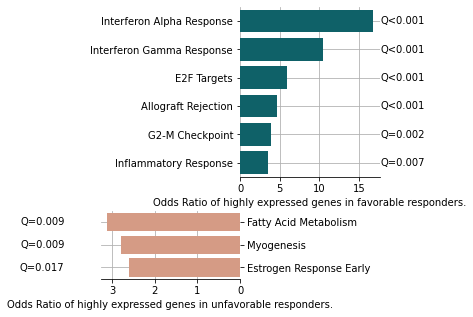

In [60]:
sub_df = df.loc[(df.Method=='DESeq2')&
                (df['Adjusted P-value']<0.05)&
                (df.Timepoint=='Baseline')&
                (df.Treatment_Arm=='Chemo->ICI'),
                :]

x='Odds Ratio'
y='Term'
hue='Direction'


fig,axs= plt.subplot_mosaic([['A','B'],
                             ['A','B'],
                             ['C','D']],figsize=(5,5))
fig.delaxes(axs['A'])
fig.delaxes(axs['D'])
## Up
data = sub_df.loc[sub_df.Direction=='Up',:].copy()
data[y] = data[y].astype(str)
order = data.sort_values(x,ascending=False)['Term']
ax = axs['B']
sns.barplot(data=data,x=x,y=y,ax=ax,order=order,color=COLOR_PAlETTE['BestResponse']['0-I'],dodge=False,zorder=3)
ax.grid(axis='both',zorder=0)

for ytick in ax.get_yticklabels():
    y_loc = ytick.get_position()[1]
    label = ytick.get_text()
    xmax = data[x].max()+1
    row = data.loc[data[y]==label,:]
    if row.size>0:
        pvalue = row['Adjusted P-value'].values[0]
        pvalue = 'Q<0.001' if pvalue <0.001 else f'Q={pvalue:.3f}'
        ax.text(x=xmax,y=y_loc,s=pvalue,color='k',va='center',ha='left')
        xmax *=1.25
ax.set(ylabel='',xlabel='Odds Ratio of highly expressed genes in favorable responders.')
ax.spines[['left']].set_visible(False)

## Down
data = sub_df.loc[sub_df.Direction=='Down',:].copy()
data[y] = data[y].astype(str)
order = data.sort_values(x,ascending=False)['Term']
ax = axs['C']
sns.barplot(data=data,x=x,y=y,ax=ax,order=order,color=COLOR_PAlETTE['BestResponse']['II-III'],dodge=False,zorder=3)
ax.yaxis.tick_right()
ax.invert_xaxis()
ax.grid(axis='both',zorder=0)
for ytick in ax.get_yticklabels():
    y_loc = ytick.get_position()[1]
    label = ytick.get_text()
    xmax = data[x].max()+1
    row = data.loc[data[y]==label,:]
    if row.size>0:
        pvalue = row['Adjusted P-value'].values[0]
        pvalue = 'Q<0.001' if pvalue <0.001 else f'Q={pvalue:.3f}'
        ax.text(x=xmax,y=y_loc,s=pvalue,color='k',va='center',ha='right')
        xmax *=1.25
ax.set(ylabel='',xlabel='Odds Ratio of highly expressed genes in unfavorable responders.')
ax.spines[['left']].set_visible(False)

plt.subplots_adjust(wspace=0,hspace=.5)
# ax.set(title='Enriched Genesets in patients with RCB=0-I. (Baseline)',ylabel='')

## ICI first

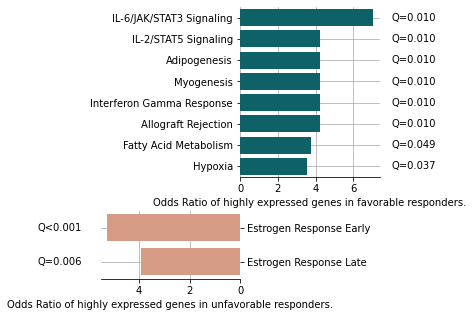

In [61]:
sub_df = df.loc[(df.Method=='DESeq2')&
                (df['Adjusted P-value']<0.05)&
                (df.Timepoint=='Baseline')&
                (df.Treatment_Arm=='ICI->Chemo'),
                :]

x='Odds Ratio'
y='Term'
hue='Direction'


fig,axs= plt.subplot_mosaic([['A','B'],
                             ['A','B'],
                             ['C','D']],figsize=(5,5))
fig.delaxes(axs['A'])
fig.delaxes(axs['D'])
## Up
data = sub_df.loc[sub_df.Direction=='Up',:].copy()
data[y] = data[y].astype(str)
order = data.sort_values(x,ascending=False)['Term']
ax = axs['B']
sns.barplot(data=data,x=x,y=y,ax=ax,order=order,color=COLOR_PAlETTE['BestResponse']['0-I'],dodge=False,zorder=3)
ax.grid(axis='both',zorder=0)

for ytick in ax.get_yticklabels():
    y_loc = ytick.get_position()[1]
    label = ytick.get_text()
    xmax = data[x].max()+1
    row = data.loc[data[y]==label,:]
    if row.size>0:
        pvalue = row['Adjusted P-value'].values[0]
        pvalue = 'Q<0.001' if pvalue <0.001 else f'Q={pvalue:.3f}'
        ax.text(x=xmax,y=y_loc,s=pvalue,color='k',va='center',ha='left')
        xmax *=1.25
ax.set(ylabel='',xlabel='Odds Ratio of highly expressed genes in favorable responders.')
ax.spines[['left']].set_visible(False)

## Down
data = sub_df.loc[sub_df.Direction=='Down',:].copy()
data[y] = data[y].astype(str)
order = data.sort_values(x,ascending=False)['Term']
ax = axs['C']
sns.barplot(data=data,x=x,y=y,ax=ax,order=order,color=COLOR_PAlETTE['BestResponse']['II-III'],dodge=False,zorder=3)
ax.yaxis.tick_right()
ax.invert_xaxis()
ax.grid(axis='both',zorder=0)
for ytick in ax.get_yticklabels():
    y_loc = ytick.get_position()[1]
    label = ytick.get_text()
    xmax = data[x].max()+1
    row = data.loc[data[y]==label,:]
    if row.size>0:
        pvalue = row['Adjusted P-value'].values[0]
        pvalue = 'Q<0.001' if pvalue <0.001 else f'Q={pvalue:.3f}'
        ax.text(x=xmax,y=y_loc,s=pvalue,color='k',va='center',ha='right')
        xmax *=1.25
ax.set(ylabel='',xlabel='Odds Ratio of highly expressed genes in unfavorable responders.')
ax.spines[['left']].set_visible(False)

plt.subplots_adjust(wspace=0,hspace=.5)
# ax.set(title='Enriched Genesets in patients with RCB=0-I. (Baseline)',ylabel='')

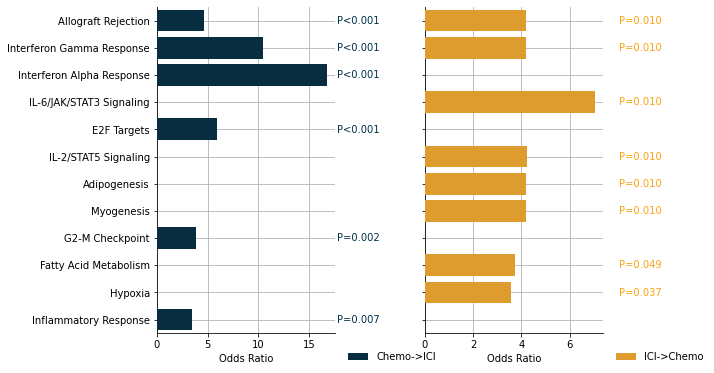

In [23]:
sub_df = df.loc[(df.Direction=='Up')&
                (df.Method=='DESeq2')&
                (df['Adjusted P-value']<0.05)&
                (df.Timepoint=='Baseline')&
                (~df.Treatment_Arm.str.contains(',')),
                :]
fig,axs= plt.subplots(1,2,figsize=(8,6),sharey=True)
x='Odds Ratio'
y='Term'
hue='Treatment_Arm'
overlap_terms = sub_df[y].value_counts()
overlap_terms = overlap_terms[overlap_terms>1].index
order = sub_df.loc[sub_df[y].isin(overlap_terms),:].groupby(y)[x].max().sort_values().index.tolist()
order = order + sub_df.loc[~sub_df[y].isin(overlap_terms),:].sort_values(by=x,ascending=False)[y].tolist()

for i,(tx,data) in enumerate(sub_df.groupby('Treatment_Arm')):
   ax=axs[i]
   sns.barplot(data=data,x=x,y=y,hue=hue,ax=ax,order=order,palette=COLOR_PAlETTE[hue],dodge=False,zorder=3)
   
   ax.legend(title='',loc=(1.05,-.1))
   ax.grid(axis='both',zorder=0)
   for ytick in axs[0].get_yticklabels():
      y_loc = ytick.get_position()[1]
      label = ytick.get_text()
      xmax = data[x].max()+1
      row = data.loc[data[y]==label,:]
      if row.size>0:
         color = COLOR_PAlETTE[hue][row[hue].values[0]]
         pvalue = row['Adjusted P-value'].values[0]
         pvalue = 'P<0.001' if pvalue <0.001 else f'P={pvalue:.3f}'
         ax.text(x=xmax,y=y_loc,s=pvalue,color=color,va='center')
         xmax *=1.25
   ax.set(ylabel='')
plt.subplots_adjust(wspace=.5)
# ax.set(title='Enriched Genesets in patients with RCB=0-I. (Baseline)',ylabel='')

[<matplotlib.collections.PathCollection object at 0x7fe0d8719f70>, <matplotlib.collections.PathCollection object at 0x7fe0d86f6190>, <matplotlib.collections.PathCollection object at 0x7fe0d86f5070>, <matplotlib.collections.PathCollection object at 0x7fe0d86df9a0>, <matplotlib.collections.PathCollection object at 0x7fe0d86df4f0>, <matplotlib.collections.PathCollection object at 0x7fe0d86f5cd0>]


/Users/jxfu/miniconda3/envs/hr_brca_16_466/lib/python3.8/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/jxfu/miniconda3/envs/hr_brca_16_466/lib/python3.8/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


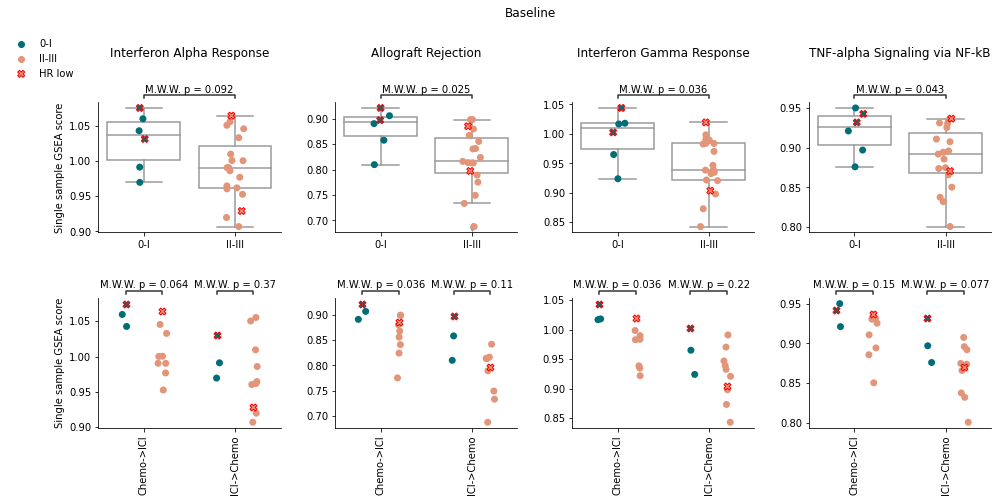

In [65]:
timepoint ='Baseline'
features = ['bulkRNA_Interferon Alpha Response_ssGSEA','bulkRNA_Allograft Rejection_ssGSEA',
            'bulkRNA_Interferon Gamma Response_ssGSEA','bulkRNA_TNF-alpha Signaling via NF-kB_ssGSEA'
            ]
fig = responsePlot_highlight_er_low(
    data=rna.loc[(rna.Timepoint==timepoint)&(rna['BestResponse']!='N/A'),:],
    features=features,ncols=len(features),ylabel='Single sample GSEA score')
plt.suptitle(timepoint,x=.5,y=1.1);

## Genes in overlapped enricher terms

[Text(5.9999999999999964, 0.5, ''),
 Text(0.5, 69.0, ''),
 Text(0.5, 1.0, 'Differentially expressed genes in baseline samples.')]

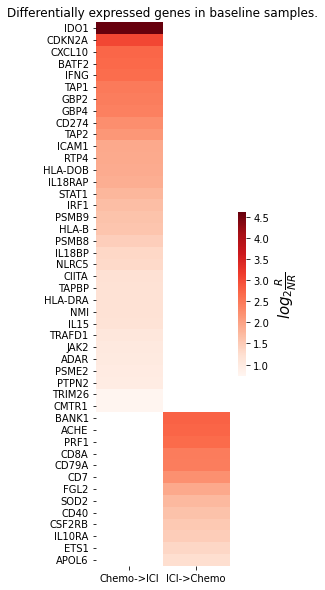

In [25]:
pvalue_threshold = 0.05
log2fc_threshold = np.log2(1.5)
genes = list(set(reduce(lambda x,y: x+y, sub_df.loc[(sub_df[y].isin(overlap_terms)),'Genes'].map(lambda x:x.split(';')).tolist())))

test_df = deg.loc[(deg.Timepoint=='Baseline')&
        (deg.Comparison=='0-I:1,II-III:0')&
        (deg.Method=='DESeq2')&
        (deg.log2FC>log2fc_threshold)&
        (deg.padj<pvalue_threshold) &
        (deg.Treatment_Arm!='Chemo->ICI,ICI->Chemo')&
        (deg.Gene.isin(genes)),:].copy()
data = test_df.pivot_table(index='Gene',columns='Treatment_Arm',values='log2FC')
fig,ax = plt.subplots(1,1,figsize=(3,10))
sns.heatmap(data.sort_values(by=['Chemo->ICI','ICI->Chemo'],ascending=False),
            cmap='Reds',
            # square=True,
            cbar_kws={"shrink": 0.3},
            ax=ax)
ax.figure.axes[-1].set_ylabel(r"$log_2 \frac{R}{NR}$",size=15)
ax.set(ylabel='',xlabel='',title='Differentially expressed genes in baseline samples.')

### Volcanoplot

In [26]:
def volcanoPlot(data,logfc,pvalue,label,label_list,log2fc_threshold=np.log2(1.5),pvalue_threshold=0.05,expr='RCB=0-I'):
    data['Group'] = 'N.S.'
    data.loc[(data[logfc]< -log2fc_threshold)&
             (data[pvalue]<pvalue_threshold),'Group'] = f'Down in {expr}'
    data.loc[(data[logfc]> log2fc_threshold)&
             (data[pvalue]<pvalue_threshold),'Group'] = f'Up in {expr}'
    data['-Log10 FDR'] = -np.log10(data[pvalue])
    colormap={
        'N.S.':'gray',
        f'Down in {expr}':'skyblue',
        f'Up in {expr}':'salmon'
    }
    fig,ax = plt.subplots(1,1,figsize=(10,5))
    for g,df in data.groupby('Group'):
        ax.scatter(df[logfc],df['-Log10 FDR'],label=g,color=colormap[g],s=10)
    ax.axvline(x=-log2fc_threshold,color='gray',ls='--')
    ax.axvline(x=log2fc_threshold,color='gray',ls='--')
    ax.axhline(y=-np.log10(pvalue_threshold),color='gray',ls='--')
    ax.set(ylabel=r'$-log_{10}(pvalue)$',xlabel=r'$log_{2}(Fold Change)$')
    texts = [ax.text(row[logfc],row['-Log10 FDR'],row[label],size=15) for _,row in data.loc[data[label].isin(label_list),:].iterrows()]
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='k'))
    ax.legend(loc=(0,1))
    return fig

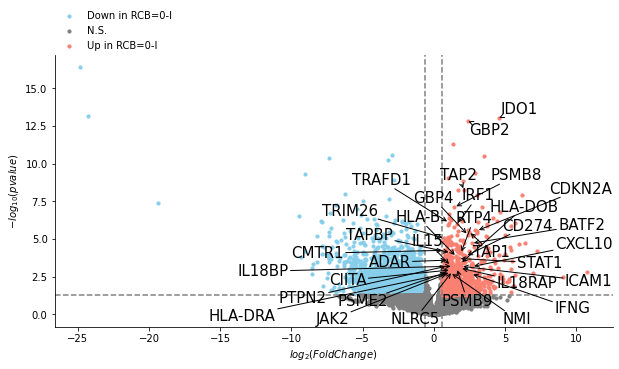

In [27]:
treatment = 'Chemo->ICI'
test_df = deg.loc[(deg.Timepoint=='Baseline')&
        (deg.Comparison=='0-I:1,II-III:0')&
        (deg.Method=='DESeq2')&
        (deg.Treatment_Arm==treatment),:].copy()

genes = list(set(reduce(lambda x,y: x+y, sub_df.loc[(sub_df[y].isin(overlap_terms))&
                                                    (sub_df["Treatment_Arm"]==treatment),'Genes'].map(lambda x:x.split(';')).tolist())))
fig=volcanoPlot(test_df,logfc='log2FC',pvalue='pvalue',label='Gene',label_list=genes)

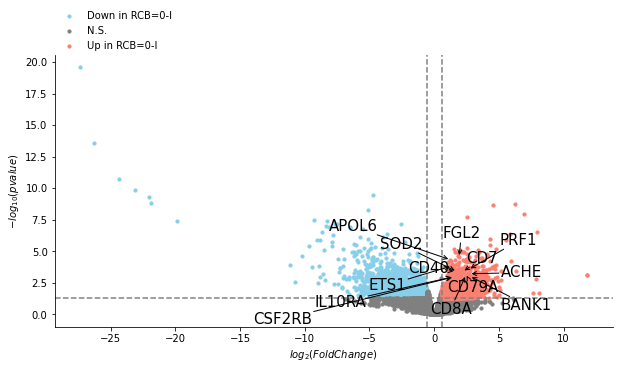

In [28]:
treatment = 'ICI->Chemo'
test_df = deg.loc[(deg.Timepoint=='Baseline')&
        (deg.Comparison=='0-I:1,II-III:0')&
        (deg.Method=='DESeq2')&
        (deg.Treatment_Arm==treatment),:].copy()

genes = list(set(reduce(lambda x,y: x+y, sub_df.loc[(sub_df[y].isin(overlap_terms))&
                                                    (sub_df["Treatment_Arm"]==treatment),'Genes'].map(lambda x:x.split(';')).tolist())))
fig=volcanoPlot(test_df,logfc='log2FC',pvalue='pvalue',label='Gene',label_list=genes)

## Enriched in NR

In [66]:
df = dataset.load('Pathways_Response')
deg = dataset.load('DEGs_Response')

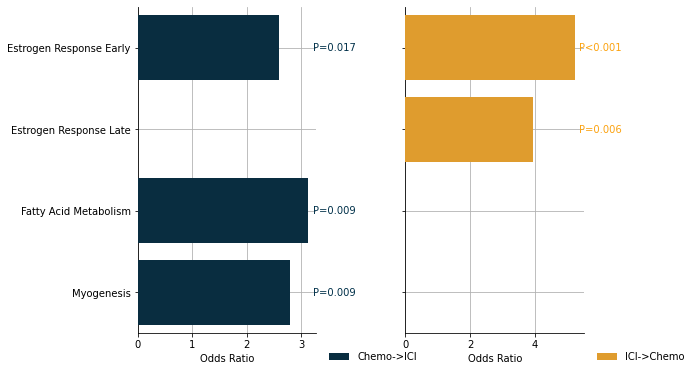

In [ ]:
sub_df = df.loc[(df.Direction=='Down')&
                (df.Method=='DESeq2')&
                (df['Adjusted P-value']<0.05)&
                (df.Timepoint=='Baseline')&
                (~df.Treatment_Arm.str.contains(',')),
                :]
fig,axs= plt.subplots(1,2,figsize=(8,6),sharey=True)
x='Odds Ratio'
y='Term'
hue='Treatment_Arm'
overlap_terms = sub_df[y].value_counts()
overlap_terms = overlap_terms[overlap_terms>1].index
order = sub_df.loc[sub_df[y].isin(overlap_terms),:].groupby(y)[x].max().sort_values().index.tolist()
order = order + sub_df.loc[~sub_df[y].isin(overlap_terms),:].sort_values(by=x,ascending=False)[y].tolist()

for i,(tx,data) in enumerate(sub_df.groupby('Treatment_Arm')):
   ax=axs[i]
   sns.barplot(data=data,x=x,y=y,hue=hue,ax=ax,order=order,palette=COLOR_PAlETTE[hue],dodge=False,zorder=3)
   
   ax.legend(title='',loc=(1.05,-.1))
   ax.grid(axis='both',zorder=0)
   for ytick in axs[0].get_yticklabels():
      y_loc = ytick.get_position()[1]
      label = ytick.get_text()
      xmax = data[x].max()+.1
      row = data.loc[data[y]==label,:]
      if row.size>0:
         color = COLOR_PAlETTE[hue][row[hue].values[0]]
         pvalue = row['Adjusted P-value'].values[0]
         pvalue = 'P<0.001' if pvalue <0.001 else f'P={pvalue:.3f}'
         ax.text(x=xmax,y=y_loc,s=pvalue,color=color,va='center')
         xmax *=1.25
   ax.set(ylabel='')
plt.subplots_adjust(wspace=.5)
# ax.set(title='Enriched Genesets in patients with RCB=0-I. (Baseline)',ylabel='')

[<matplotlib.collections.PathCollection object at 0x7fe0bcb0ffa0>, <matplotlib.collections.PathCollection object at 0x7fe0c264f040>, <matplotlib.collections.PathCollection object at 0x7fe0bcf120d0>, <matplotlib.collections.PathCollection object at 0x7fe0bcf12070>, <matplotlib.collections.PathCollection object at 0x7fe0bcb0fa90>, <matplotlib.collections.PathCollection object at 0x7fe0c2cdcb20>]


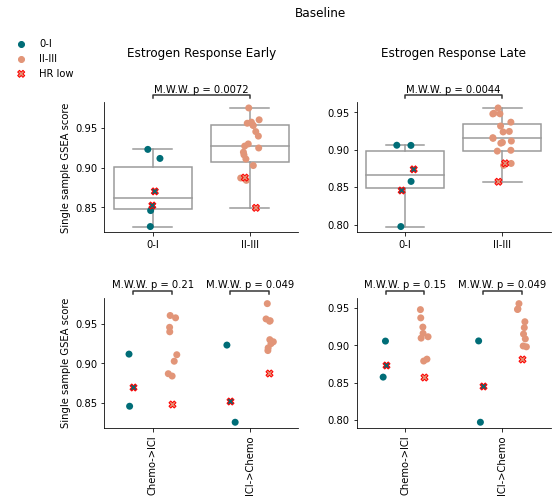

In [67]:
timepoint ='Baseline'
features = ['bulkRNA_Estrogen Response Early_ssGSEA','bulkRNA_Estrogen Response Late_ssGSEA',
            ]
fig = responsePlot_highlight_er_low(
    data=rna.loc[(rna.Timepoint==timepoint)&(rna['BestResponse']!='N/A'),:],
    features=features,ncols=len(features),ylabel='Single sample GSEA score')
plt.suptitle(timepoint,x=.5,y=1.1);

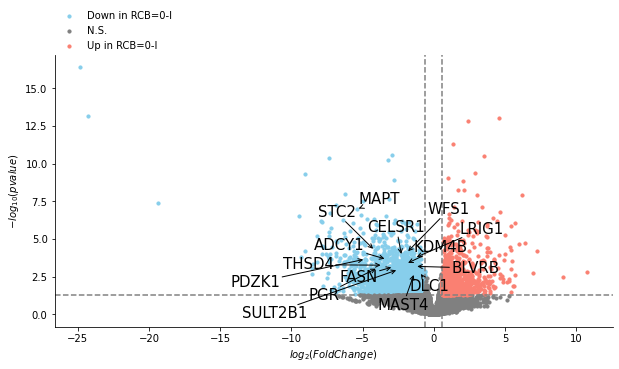

In [81]:
treatment = 'Chemo->ICI'
test_df = deg.loc[(deg.Timepoint=='Baseline')&
        (deg.Comparison=='0-I:1,II-III:0')&
        (deg.Method=='DESeq2')&
        (deg.Treatment_Arm==treatment),:].copy()

genes = list(set(reduce(lambda x,y: x+y, sub_df.loc[(sub_df[y].isin(overlap_terms))&
                                                    (sub_df["Treatment_Arm"]==treatment),'Genes'].map(lambda x:x.split(';')).tolist())))
fig=volcanoPlot(test_df,logfc='log2FC',pvalue='pvalue',label='Gene',label_list=genes)

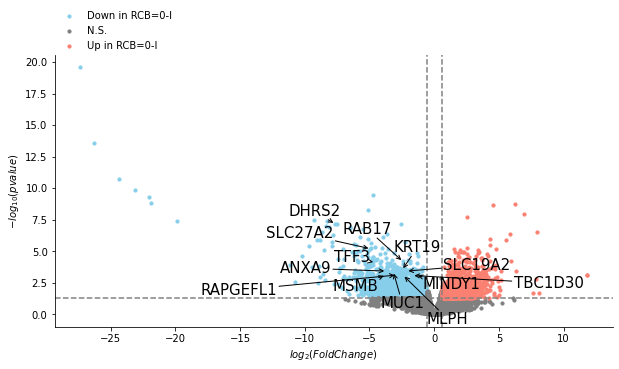

In [82]:
treatment = 'ICI->Chemo'
test_df = deg.loc[(deg.Timepoint=='Baseline')&
        (deg.Comparison=='0-I:1,II-III:0')&
        (deg.Method=='DESeq2')&
        (deg.Treatment_Arm==treatment),:].copy()

genes = list(set(reduce(lambda x,y: x+y, sub_df.loc[(sub_df[y].isin(overlap_terms))&
                                                    (sub_df["Treatment_Arm"]==treatment),'Genes'].map(lambda x:x.split(';')).tolist())))
fig=volcanoPlot(test_df,logfc='log2FC',pvalue='pvalue',label='Gene',label_list=genes)

In [83]:
pvalue_threshold = 0.05
log2fc_threshold = np.log2(1.5)
genes = list(set(reduce(lambda x,y: x+y, sub_df.loc[sub_df[y].isin(overlap_terms),'Genes'].map(lambda x:x.split(';')).tolist())))
test_df = deg.loc[(deg.Timepoint=='Baseline')&
        (deg.Comparison=='0-I:1,II-III:0')&
        (deg.Method=='DESeq2')&
        (deg.log2FC<-log2fc_threshold)&
        (deg.padj<pvalue_threshold) &
        (deg.Treatment_Arm!='Chemo->ICI,ICI->Chemo')&
        (deg.Gene.isin(genes)),:].copy()

data = test_df.pivot_table(index='Gene',columns='Treatment_Arm',values='log2FC')
data.sort_values('Chemo->ICI')

Treatment_Arm,Chemo->ICI,ICI->Chemo
Gene,,
MAPT,-5.383275,NaN
PDZK1,-4.811225,NaN
STC2,-4.157171,NaN
PGR,-3.940219,NaN
THSD4,-3.585381,NaN
ADCY1,-3.320614,NaN
FASN,-2.844102,NaN
SULT2B1,-2.501624,NaN
CELSR1,-2.249279,NaN


## Store ssGSEA

In [84]:
features = ['bulkRNA_Interferon Alpha Response_ssGSEA','bulkRNA_Allograft Rejection_ssGSEA',
            'bulkRNA_Interferon Gamma Response_ssGSEA','bulkRNA_TNF-alpha Signaling via NF-kB_ssGSEA'
            ]
rna_sheets['TableB ssGSEA scores']=rna.loc[:,features].copy()

#  Repeat the pathway analysis on patients without AC

In [85]:
df = dataset.load('NoAC_Pathways_Response')
deg = dataset.load('NoAC_DEGs_Response')

In [86]:
metadata.loc[(metadata.Timepoint=='Baseline')&
             (metadata.AC_Treatment=='No'),['Treatment_Arm','BestResponse']].value_counts()

Treatment_Arm  BestResponse
ICI->Chemo     II-III          6
Chemo->ICI     0-I             3
               II-III          3
ICI->Chemo     0-I             1
dtype: int64

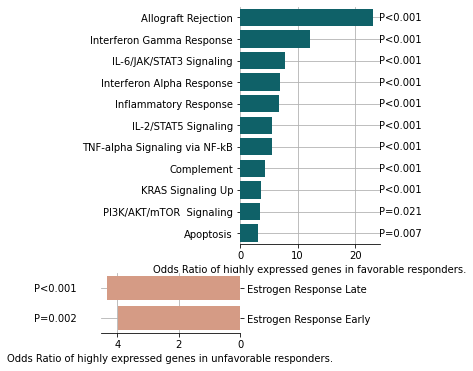

In [87]:
sub_df = df.loc[(df.Method=='DESeq2')&
                (df['Adjusted P-value']<0.05)&
                (df.Timepoint=='Baseline')&
                (df.Treatment_Arm=='Chemo->ICI,ICI->Chemo'),
                :]

x='Odds Ratio'
y='Term'
hue='Direction'


fig,axs= plt.subplot_mosaic([['A','B'],
                             ['A','B'],
                             ['A','B'],
                             ['C','D']],figsize=(5,6))
fig.delaxes(axs['A'])
fig.delaxes(axs['D'])
## Up
data = sub_df.loc[sub_df.Direction=='Up',:].copy()
data[y] = data[y].astype(str)
order = data.sort_values(x,ascending=False)['Term']
ax = axs['B']
sns.barplot(data=data,x=x,y=y,ax=ax,order=order,color=COLOR_PAlETTE['BestResponse']['0-I'],dodge=False,zorder=3)
ax.grid(axis='both',zorder=0)

for ytick in ax.get_yticklabels():
    y_loc = ytick.get_position()[1]
    label = ytick.get_text()
    xmax = data[x].max()+1
    row = data.loc[data[y]==label,:]
    if row.size>0:
        pvalue = row['Adjusted P-value'].values[0]
        pvalue = 'P<0.001' if pvalue <0.001 else f'P={pvalue:.3f}'
        ax.text(x=xmax,y=y_loc,s=pvalue,color='k',va='center',ha='left')
        xmax *=1.25
ax.set(ylabel='',xlabel='Odds Ratio of highly expressed genes in favorable responders.')
ax.spines[['left']].set_visible(False)

## Down
data = sub_df.loc[sub_df.Direction=='Down',:].copy()
data[y] = data[y].astype(str)
order = data.sort_values(x,ascending=False)['Term']
ax = axs['C']
sns.barplot(data=data,x=x,y=y,ax=ax,order=order,color=COLOR_PAlETTE['BestResponse']['II-III'],dodge=False,zorder=3)
ax.yaxis.tick_right()
ax.invert_xaxis()
ax.grid(axis='both',zorder=0)
for ytick in ax.get_yticklabels():
    y_loc = ytick.get_position()[1]
    label = ytick.get_text()
    xmax = data[x].max()+1
    row = data.loc[data[y]==label,:]
    if row.size>0:
        pvalue = row['Adjusted P-value'].values[0]
        pvalue = 'P<0.001' if pvalue <0.001 else f'P={pvalue:.3f}'
        ax.text(x=xmax,y=y_loc,s=pvalue,color='k',va='center',ha='right')
        xmax *=1.25
ax.set(ylabel='',xlabel='Odds Ratio of highly expressed genes in unfavorable responders.')
ax.spines[['left']].set_visible(False)

plt.subplots_adjust(wspace=0,hspace=.5)
# ax.set(title='Enriched Genesets in patients with RCB=0-I. (Baseline)',ylabel='')

# Immune infiltration

In [68]:
df = dataset.load('Feature_Response')
df.loc[(df.Feature.str.endswith('CIBERSORT-ABS')),'Feature'].nunique()
rna_sheets['TableB Immune Infiltration']=df.loc[(df.Feature.str.endswith('CIBERSORT-ABS')),:].drop(['padj'],axis=1).copy()

In [69]:
df = dataset.load('Feature_Response')
df = df.loc[(df.Feature.str.contains('-ABS'))&
            (df.Timepoint=='Baseline')&
            (df.Comparison=='0-I:1,II-III:0')&
            (df.Pvalue<0.05)&
            (df.Treatment_Arm=='Chemo->ICI,ICI->Chemo'),:].sort_values('Pvalue')
df

,Feature,Zscore,Pvalue,Method,padj,Timepoint,Treatment_Arm,Comparison,N_Sample
850,bulkRNA_T cell CD8+_CIBERSORT-ABS,1.204671,0.005624,Wilcoxon,0.136099,Baseline,"Chemo->ICI,ICI->Chemo","0-I:1,II-III:0","0.0:19,1.0:6"
861,bulkRNA_Macrophage M1_CIBERSORT-ABS,1.520925,0.036081,Wilcoxon,0.269237,Baseline,"Chemo->ICI,ICI->Chemo","0-I:1,II-III:0","0.0:19,1.0:6"
853,bulkRNA_T cell CD4+ memory activated_CIBERSORT...,1.655858,0.042778,Wilcoxon,0.269237,Baseline,"Chemo->ICI,ICI->Chemo","0-I:1,II-III:0","0.0:19,1.0:6"


[<matplotlib.collections.PathCollection object at 0x7fe0c2c37fa0>, <matplotlib.collections.PathCollection object at 0x7fe0beaf8f10>, <matplotlib.collections.PathCollection object at 0x7fe0beb11130>, <matplotlib.collections.PathCollection object at 0x7fe0beb11490>, <matplotlib.collections.PathCollection object at 0x7fe0beb115b0>, <matplotlib.collections.PathCollection object at 0x7fe0beb06b20>]


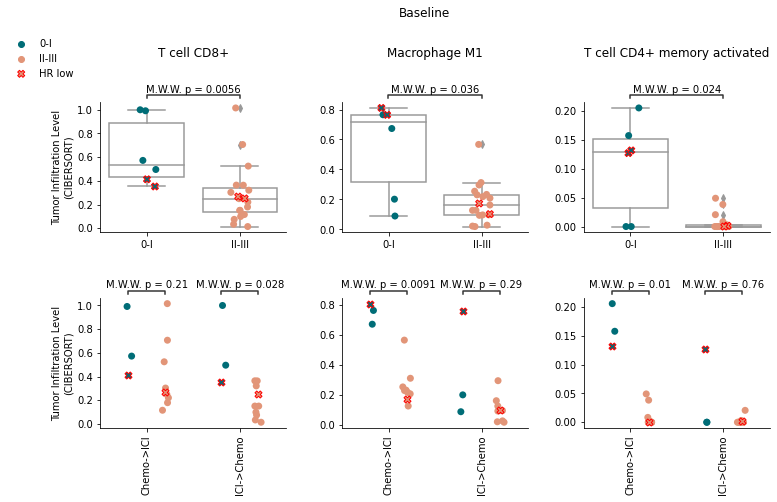

In [72]:
timepoint ='Baseline'
features = df.Feature.unique().tolist()
fig = responsePlot_highlight_er_low(
    data=rna.loc[(rna.Timepoint==timepoint)&(rna['BestResponse']!='N/A'),:],
    features=features,ncols=len(features),ylabel='Tumor Infiltration Level\n(CIBERSORT)')
plt.suptitle(timepoint,x=.5,y=1.1);
for ax in fig.get_axes():
    ax.set_title(label=ax.get_title().replace('_CIBERSORT-ABS',''),y=1.3)

# Cytokine

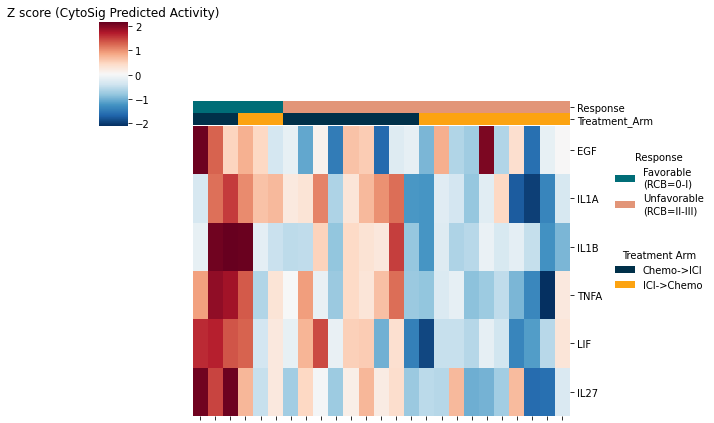

In [40]:
df = dataset.load('Feature_Response')
df = df.loc[(df.Feature.str.contains('Cytokine_'))&
            (df.Timepoint=='Baseline')&
            (df.Comparison=='0-I:1,II-III:0')&
            (df.Treatment_Arm=='Chemo->ICI,ICI->Chemo'),:]
rna_sheets['TableC Cytokine']=df.drop(['padj'],axis=1).copy()
df = df.loc[df.Pvalue<0.05,:]
cytokine_columns= df.sort_values('Zscore').Feature.unique()
# cytokine_columns = rna.columns[rna.columns.str.contains('Cytokine_')]
bl_rna = rna.loc[(rna.BestResponse!='N/A')&
               (rna.Timepoint=='Baseline'),:].copy()
data = bl_rna[cytokine_columns]
data.columns = data.columns.str.replace('bulkRNA_Cytokine_','')

row_colors = pd.concat([bl_rna['BestResponse'].map(COLOR_PAlETTE['BestResponse']).rename('Response'),
                        bl_rna['Treatment_Arm'].map(COLOR_PAlETTE['Treatment_Arm'])]
        ,axis=1)

# col_order = cytokine_columns#data.mean(axis=0).sort_values(ascending=False).index
row_order = row_colors.sort_values(['Response','Treatment_Arm']).index
g=sns.clustermap(data.loc[row_order,:].T,cmap='RdBu_r',
            col_colors=row_colors,
            col_cluster=False,
            row_cluster=False,
            z_score=0,
            figsize=(8,8))
g.ax_heatmap.set_xticklabels([]);
g.ax_heatmap.tick_params(rotation=360)
g.ax_heatmap.set(xlabel='');
g.ax_cbar.set_title('Z score (CytoSig Predicted Activity)')
from matplotlib.patches import Patch

lut = COLOR_PAlETTE['BestResponse'].copy()
del lut['N/A']
lut['Favorable\n(RCB=0-I)'] = lut.pop('0-I')
lut['Unfavorable\n(RCB=II-III)'] = lut.pop('II-III')
handles = [Patch(facecolor=lut[name]) for name in lut]
l1 = plt.legend(handles, lut, title='Response',
           bbox_to_anchor=(.9, .7), bbox_transform=plt.gcf().transFigure, loc='center left')


lut = COLOR_PAlETTE['Treatment_Arm'].copy()
del lut['N/A']
handles = [Patch(facecolor=lut[name]) for name in lut]
l2 = plt.legend(handles, lut, title='Treatment Arm',
           bbox_to_anchor=(.9, .55), bbox_transform=plt.gcf().transFigure, loc='center left')
plt.gca().add_artist(l1)

# Store RNA table

In [92]:
with pd.ExcelWriter(RnaTableFile) as f:
    for k,v in rna_sheets.items():
        v.to_excel(f,sheet_name=k)